In [8]:
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from Evaluation.Evaluator import EvaluatorHoldout
from Data_Handler.DataReader import DataReader
import scipy.sparse as sps
from collections import Counter
from tqdm import tqdm
# imports for .env usage
import os
from dotenv import load_dotenv
load_dotenv()



True

In [9]:
from Data_Handler.DataReader import DataReader 
dataReader=DataReader()
'''urm=dataReader.load_augmented_binary_urm()
powerful_urm=dataReader.load_powerful_binary_urm()
URM_pad,icm = dataReader.pad_with_zeros_ICMandURM(urm)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(urm, train_percentage = 0.9)
train_powerful, val_powerful = split_train_in_two_percentage_global_sample(powerful_urm, train_percentage = 0.9)
train_pad, val_pad = split_train_in_two_percentage_global_sample(URM_pad, train_percentage = 0.9)'''

URM = dataReader.load_augmented_binary_urm()
URM_aug,icm = dataReader.pad_with_zeros_ICMandURM(URM)

URM_train_aug, URM_validation = split_train_in_two_percentage_global_sample(URM_aug, train_percentage = 0.9)
URM_train_pow = dataReader.stackMatrixes(URM_train_aug)

4877


In [10]:
profile_length = np.ediff1d(sps.csr_matrix(URM_train_aug).indptr)
profile_length, profile_length.shape

(array([57, 21, 93, ..., 22, 49, 20], dtype=int32), (41629,))

In [11]:
block_size = int(len(profile_length)*0.1)
block_size

4162

In [12]:
sorted_users = np.argsort(profile_length)
sorted_users

array([37398, 21852, 38400, ..., 19407,  8693, 12454])

In [13]:
for group_id in range(0, 10):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 4162, average p.len 12.88, median 13.0, min 4, max 15
Group 1, #users in group 4162, average p.len 16.63, median 17.0, min 15, max 18
Group 2, #users in group 4162, average p.len 19.15, median 19.0, min 18, max 20
Group 3, #users in group 4162, average p.len 21.63, median 22.0, min 20, max 23
Group 4, #users in group 4162, average p.len 24.27, median 24.0, min 23, max 26
Group 5, #users in group 4162, average p.len 27.50, median 27.0, min 26, max 29
Group 6, #users in group 4162, average p.len 31.82, median 32.0, min 29, max 35
Group 7, #users in group 4162, average p.len 38.39, median 38.0, min 35, max 43
Group 8, #users in group 4162, average p.len 49.57, median 49.0, min 43, max 59
Group 9, #users in group 4162, average p.len 92.74, median 77.0, min 59, max 517


In [14]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from hybrid import HybridRecommender_4
from Recommenders.SLIM.SLIMElasticNetRecommender import *
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

from Recommenders.FactorizationMachines.LightFMRecommender import LightFMItemHybridRecommender

MAP_recommender_per_group = {}

UserKNNCF = UserKNNCFRecommender(URM_train_aug)
UserKNNCF.fit()

RP3beta_pow = RP3betaRecommender(URM_train_pow)
RP3beta_pow.fit(alpha=0.3648761546066018,beta=0.5058870363874656, topK=480, normalize_similarity=True)

S_SLIM = SLIMElasticNetRecommender(URM_train_pow)
S_SLIM.fit()

collaborative_recommender_class = {
        "SLIMElasticNetRecommender": SLIMElasticNetRecommender,
        "UserKNNCF": UserKNNCFRecommender,
        "ItemKNNCF": ItemKNNCFRecommender,
        "RP3betaRecommender": RP3betaRecommender,
        "EASE_R": EASE_R_Recommender,
        "Hybrid_Recommender_4" : HybridRecommender_4,
}

recommender_object_dict = {}
recommended_items_for_each_user = {}

for label, recommender_class in collaborative_recommender_class.items():
    if(label == "SLIMElasticNetRecommender" or label== "RP3betaRecommender"):
        recommender_object = recommender_class(URM_train_pow)
        recommender_object.fit()
    elif label == "HybridRecommender_4":
        recommender_object = recommender_class(URM_train_aug, URM_train_pow, UserKNNCF, RP3beta_pow, S_SLIM)
        recommender_object.fit(UserKNNCF_tier1_weight=0.9, RP3beta_pow_tier1_weight=0.6,UserKNNCF_tier2_weight=0.7, RP3beta_pow_tier2_weight=0.9, RP3beta_pow_tier3_weight=0.6, S_SLIM_tier3_weight=1.0)

    else:
        recommender_object = recommender_class(URM_train_aug)
        recommender_object.fit()
    recommender_object_dict[label] = recommender_object


UserKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 676.82 column/sec. Elapsed time 1.03 min
RP3betaRecommender: Similarity column 27968 (100.0%), 1803.76 column/sec. Elapsed time 15.51 sec
SLIMElasticNetRecommender: Processed 8203 (29.3%) in 5.00 min. Items per second: 27.34
SLIMElasticNetRecommender: Processed 16964 (60.7%) in 10.00 min. Items per second: 28.27
SLIMElasticNetRecommender: Processed 27968 (100.0%) in 14.71 min. Items per second: 31.69
UserKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 838.67 column/sec. Elapsed time 49.64 sec
ItemKNNCFRecommender: URM Detected 3461 (12.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 27968 (100.0%), 955.20 column/sec. Elapsed time 29.28 

TypeError: HybridRecommender_4.__init__() missing 3 required positional arguments: 'UserKNNCF', 'RP3beta_pow', and 'S_SLIM'

In [15]:
evaluator=EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2868 ( 6.9%) Users that have less than 1 test interactions


In [16]:
from evaluator import evaluate
cutoff = 10

for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    #evaluator_power = EvaluatorHoldout(val_powerful, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    #evaluator_pad = EvaluatorHoldout(val_pad, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        '''if(label == "SLIMElasticNetRecommender"):
            #map=evaluate(recommended_items_for_each_user,val_powerful,target)
            result_df, _ = evaluator_power.evaluateRecommender(recommender)'''
        
        #map=evaluate(recommended_items_for_each_user,URM_validation,target)
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
            
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
            #MAP_recommender_per_group[label].append(map)
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
            #MAP_recommender_per_group[label] = [map]


Group 0, #users in group 4162, average p.len 12.88, median 13.0, min 4, max 15
EvaluatorHoldout: Ignoring 2868 ( 6.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 37467 Users
EvaluatorHoldout: Processed 3578 (100.0%) in 2.74 sec. Users per second: 1307
EvaluatorHoldout: Processed 3578 (100.0%) in 2.93 sec. Users per second: 1222
EvaluatorHoldout: Processed 3578 (100.0%) in 2.00 sec. Users per second: 1793
EvaluatorHoldout: Processed 3578 (100.0%) in 1.93 sec. Users per second: 1854
EvaluatorHoldout: Processed 3578 (100.0%) in 6.01 sec. Users per second: 595
Group 1, #users in group 4162, average p.len 16.63, median 17.0, min 15, max 18
EvaluatorHoldout: Ignoring 2868 ( 6.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 37467 Users
EvaluatorHoldout: Processed 3636 (100.0%) in 2.53 sec. Users per second: 1436
EvaluatorHoldout: Processed 3636 (100.0%) in 2.75 sec. Users per second: 1323
EvaluatorHoldout: Processed 3636 (100.0%) in 1

10
10
10
10
10


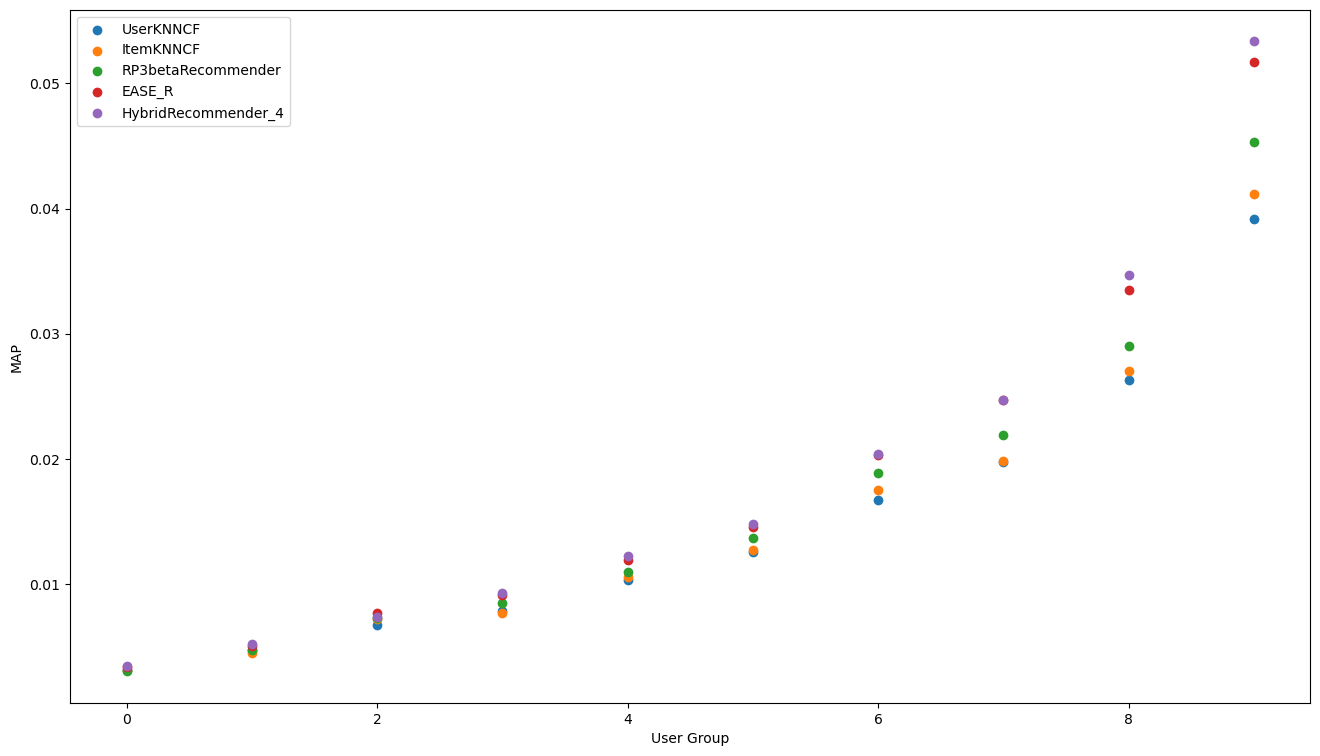

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
    print(len(results))
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()